# *Import Libraries:*

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from albumentations import Compose, Resize, HorizontalFlip, VerticalFlip
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('MASK')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('MASK')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')
        

# *Configurations:*

In [3]:
CSV_FILE = 'train.csv'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [4]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [5]:
row = df.iloc[2]

image = cv2.imread(row['images'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(row['masks'], cv2.IMREAD_GRAYSCALE)

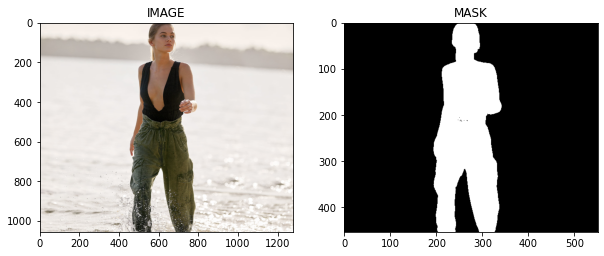

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask,cmap = 'gray')

In [7]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 123)

# *Augmentation:*

In [8]:
def get_train_augs():
    return Compose([
        Resize(IMG_SIZE, IMG_SIZE),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5)
    ], is_check_shapes=False)

def get_valid_augs():
    return Compose([
        Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)

# *Custom Dataset:*

In [9]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]

        image = cv2.imread(row['images'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(row['masks'], cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image = image, mask = mask)
            image = data['image']
            mask = data['mask']

        # (h, w, c) -> (c, h, w)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        image = torch.Tensor(image) / 255.
        mask = torch.round(torch.Tensor(mask) / 255.)

        return image, mask

In [10]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [11]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


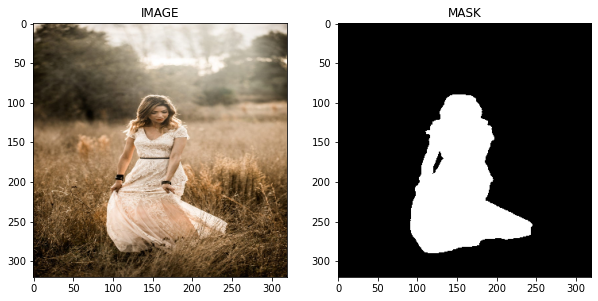

In [12]:
index = 3
image, mask = trainset[index]
show_image(image, mask)

# *Load dataset:*

In [13]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [15]:
image, mask = next(iter(trainloader))
print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# *Create Model:*

In [16]:
class SegmentationModel(nn.Module):
    
    def __init__(self):
        super(SegmentationModel, self).__init__()
        
        self.arc = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None
        )
        
    def forward(self, images, masks = None):
        logits = self.arc(images)
        
        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2
        
        return logits

In [17]:
model = SegmentationModel()
model.to(DEVICE);

# *Train and Validation Function:*

In [18]:
def train_model(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    
    for data in tqdm(data_loader):
        
        images, masks = data
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(data_loader)

def eval_model(data_loader, model):
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss / len(data_loader)

# *Train Model:*

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [20]:
best_valid_loss = np.inf

for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    valid_loss = eval_model(validloader, model)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("SAVED-MODEL")
        best_valid_loss = valid_loss
        
    print(f"Epoch : {i+1} ----- Train loss : {train_loss} ----- Valid loss : {valid_loss}")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

SAVED-MODEL
Epoch : 1 ----- Train loss : 0.8515869081020355 ----- Valid loss : 1.7374804615974426


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

SAVED-MODEL
Epoch : 2 ----- Train loss : 0.35961722731590273 ----- Valid loss : 0.3568020612001419


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 3 ----- Train loss : 0.324830158551534 ----- Valid loss : 0.43782930821180344


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

SAVED-MODEL
Epoch : 4 ----- Train loss : 0.2892515202363332 ----- Valid loss : 0.25797776877880096


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

SAVED-MODEL
Epoch : 5 ----- Train loss : 0.2780969520409902 ----- Valid loss : 0.25326692312955856


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

SAVED-MODEL
Epoch : 6 ----- Train loss : 0.22431931893030801 ----- Valid loss : 0.2317749336361885


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 7 ----- Train loss : 0.21489220559597016 ----- Valid loss : 0.25881263613700867


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

SAVED-MODEL
Epoch : 8 ----- Train loss : 0.24782138019800187 ----- Valid loss : 0.2311970219016075


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 9 ----- Train loss : 0.208428093791008 ----- Valid loss : 0.23836127668619156


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

SAVED-MODEL
Epoch : 10 ----- Train loss : 0.18700381815433503 ----- Valid loss : 0.19201860204339027


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

SAVED-MODEL
Epoch : 11 ----- Train loss : 0.14594630698362987 ----- Valid loss : 0.18475384078919888


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 12 ----- Train loss : 0.18313695043325423 ----- Valid loss : 0.2523634508252144


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 13 ----- Train loss : 0.16940759519735973 ----- Valid loss : 0.19067306630313396


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 14 ----- Train loss : 0.18627067804336547 ----- Valid loss : 0.19759765081107616


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 15 ----- Train loss : 0.15377427240212757 ----- Valid loss : 0.2622111588716507


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 16 ----- Train loss : 0.14808062414328257 ----- Valid loss : 0.2060021609067917


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 17 ----- Train loss : 0.1375574514269829 ----- Valid loss : 0.22103818506002426


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

SAVED-MODEL
Epoch : 18 ----- Train loss : 0.13670223504304885 ----- Valid loss : 0.17803743854165077


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 19 ----- Train loss : 0.14016943176587424 ----- Valid loss : 0.23082545027136803


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

SAVED-MODEL
Epoch : 20 ----- Train loss : 0.12448435674111048 ----- Valid loss : 0.1666217241436243


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 21 ----- Train loss : 0.10574876815080643 ----- Valid loss : 0.23155883327126503


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

SAVED-MODEL
Epoch : 22 ----- Train loss : 0.10512324422597885 ----- Valid loss : 0.16138115152716637


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 23 ----- Train loss : 0.10403925875822703 ----- Valid loss : 0.19436659291386604


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 24 ----- Train loss : 0.10899994770685832 ----- Valid loss : 0.23979787155985832


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 25 ----- Train loss : 0.10506914059321086 ----- Valid loss : 0.24051376432180405


In [21]:
index = 30

model.load_state_dict(torch.load('best_model.pt'))

image, mask = validset[index]

logits_mask = model(image.to(DEVICE).unsqueeze(0))

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

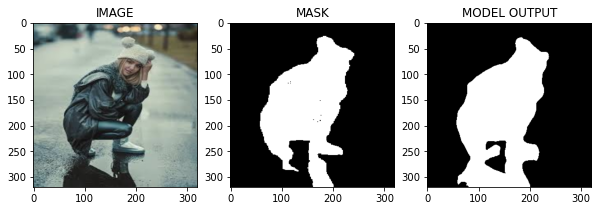

In [22]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))